# Notebook de treino do modelo: 
Neste notebook o cliente treinará o modelo que será utilizado para fazer classifcações em novos inputs feitos na base de dados e, desta forma, classifcar novos RT's através de uma métrica preestabelecida. A ideia geral é que sejam utilizados dados passados para fazer este treino e posteriormente utilizar este modelo treinado para classifcar novas entradas de dados.

In [7]:
#===============================================================================
# Esta célula conecta ao seu drive diretamente, é necessário executá-la para 
# fazer a leiture das tabelas utilizadas para construir o modelo
#===============================================================================
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
#=============================================================================== 
# Esta célula remove os avisos de células que tem execução muito lenta ou de
# funções que são reutilizadas em outras seções e não necessitam mostrar o mesmo 
# aviso
#=============================================================================== 
import warnings
warnings.filterwarnings('ignore')

# Poderações inciais: 

O Notebook não mantém a mesma formatação do Google Colaboratory quando exportado para o GitHub, portanto, segue link para acesso no drive montado pelo grupo: 

https://colab.research.google.com/drive/1zcICZj-_3deblgSRMGAcs2RWqd-sARM_?usp=sharing

É necessário que o cliente altere o caminho relativo para as planilhas, de modo que seja possível utilizar o notebook para obtenção do output do modelo preditivo. 

---

## Tabelas Necessárias:
A princípio, devemos padronizar as planilhas que serão utilizadas. Segue a lista das tabelas disponibilizadas pela Rappi (https://drive.google.com/drive/folders/18yMhpE-YkF8RF-a74u7A6Cm-1B7LdzrS) que devem ser utilizadas, estas devem conter os mesmos dados, estritamente: 
</br>
Tabela "earnings"
</br> 
Tabela "new_supply" 
</br>
Tabela "infos gerais"
</br>
Tabela "attendance Rate" 
</br>
Tabela "Incidentes_Regras RT"
</br>
Tabela "Ordens Done e Cancel"
</br>
Tabela "Product return" 
</br>
Tabela "comp defects" 
</br>
Tabela "criacao contas churn" 
</br>
Tabela "tempo resolucao e modal" 
</br>
Tabela "distance to user" 

--- 

Após a executar a primeira célula contida neste Notebook, o  acesso aos arquivos contidos no seu Drive pessoal (MyDrive) ou compartilhado (Shareddrives) estarão na seção "Arquivos" na barra lateral à esquerda, também é possível clicar no ícone de pasta na mesma barra e acessar facilmente a seção. A partir daí, você deve procurar os arquivos requisitados acima e copiar seu caminho, clicando com o botão direito no arquivo desejado. Exemplo abaixo:
<br><br>
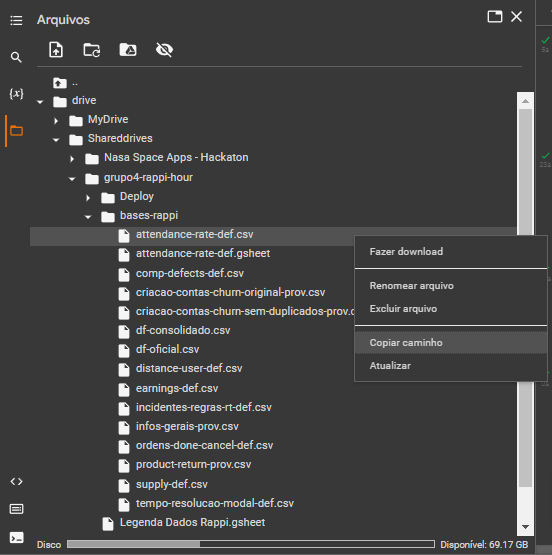

Após o caminho do arquivo ser copiado, você deve colá-lo no respectivo campo indicado na celula abaixo, ou seja, se o caminho da planilha "infos gerais", por exemplo, for copiado, você deverá procurar o campo onde está escrito tabela_infos_gerais e, no respectivo espaço vazio, deve colar o caminho que foi copiado, um ctrl + v, caso utilize Windows, ou command + v, no caso de utilizar sistemas Apple, pode ajudar.


Perceba que a estrutura do caminho se refere a estrutura de pastas do drive. 
</br> 
"/content/drive/Shareddrives/grupo4-rappi-hour/bases-rappi/infos-gerais-prov.csv"
</br> 
Neste caso, o caminho se refere a um drive compartilhado (Shareddrives), do grupo 4 "Rappi Hour", na pasta "bases-rappi" e ele referencia o arquivo "infos-gerais-prov" em formato csv.

In [9]:
#@markdown Preencha os campos abaixos com as respectivas tabelas
#@title Célula de Tratamento de Dados 
tabela_earnings = "" #@param {type:"string"}
tabela_supply = "" #@param {type:"string"}
tabela_infos_gerais = "" #@param {type:"string"}
tabela_attendance_rate = "" #@param {type:"string"}
tabela_Incidentes_Regras_RT = "" #@param {type:"string"}
tabela_Ordens_Done_e_Cancel = "" #@param {type:"string"}
tabela_Product_return = "" #@param {type:"string"}
tabela_comp_defects = "" #@param {type:"string"}
tabela_criacao_contas_churn = "" #@param {type:"string"}
tabela_tempo_resolucao_e_modal = "" #@param {type:"string"}
tabela_distance_to_user = "" #@param {type:"string"}
#========================================================
# Import das bibliotecas utilizadas
#========================================================
import numpy as np
import pandas as pd
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgb

#--------------------------------------------------------

#========================================================
# Leituras das tabelas necessárias para análise dos dados
#========================================================
df_earnings = pd.read_csv(tabela_earnings)
df_supply = pd.read_csv(tabela_supply)
df_info = pd.read_csv(tabela_infos_gerais)
df_attendance = pd.read_csv(tabela_attendance_rate)
df_incidentes = pd.read_csv(tabela_Incidentes_Regras_RT)
df_orders = pd.read_csv(tabela_Ordens_Done_e_Cancel)
df_productReturn = pd.read_csv(tabela_Product_return)
df_defects = pd.read_csv(tabela_comp_defects)
df_churn = pd.read_csv(tabela_criacao_contas_churn)
df_resTime = pd.read_csv(tabela_tempo_resolucao_e_modal)
df_distance = pd.read_csv(tabela_distance_to_user)

#-------------------------------------------------------

#=======================================================
# Tratamento de dados e produção das features 
#=======================================================

# ======================================================
# Base: DF churn && DF info
# ======================================================
df_churn.drop(labels="Unnamed: 0", axis=1, inplace = True)
df_churn_ = (df_churn["CITY"].value_counts(normalize=True).cumsum() < 0.8).to_frame()
df_churn_ = df_churn_[df_churn_["CITY"] == True]
filter = df_churn_.index.to_list()
df_churn__ = df_churn[df_churn['CITY'].isin(filter)]

df_info.replace(
    {"CIDADE": {
        'Sao Paulo': 'Grande São Paulo',
        'São Paulo': 'Grande São Paulo',
        'SÃO PAULO': 'Grande São Paulo',
        'BELO HORIZINTE': 'Belo Horizonte',
        'RIO DE JANEIRO': 'Rio de Janeiro'
    }}, inplace=True
)
df_info_ = df_info[df_info['CIDADE'].isin(filter)]

filter = df_churn__["ID"].to_list()
mask = df_info_["ID"].isin(filter)
column_name = "IS_ACTIVE"
df_info_.loc[mask, column_name] = "Quasi"

filter = df_info_["ID"].to_list()
mask = ~df_churn__["ID"].isin(filter)
df_churn__ = df_churn__[mask]

df_churn__.rename(columns={
    "FIRST_NAME": "NOME", 
    "GENDER": "GENERO",
    "CITY": "CIDADE",
    "TRANSPORT_MEDIA_TYPE": "TRANSPORTE"
    }, inplace=True)

df_churn__.drop(columns=["SK.CREATED_AT::DATE", "CARTAO", "FECHA_ULT", "LEVEL_NAME"], inplace=True)
df_churn__["IS_ACTIVE"] = False

df_consol = pd.concat([df_info_, df_churn__])
df_consol.drop(columns=["NOME", "SOBRENOME"], inplace=True)

df_consol["DATA_NASCIMENTO"] = df_consol["DATA_NASCIMENTO"].map(lambda x : x[:4], na_action="ignore")
df_consol["DATA_NASCIMENTO"] = pd.to_numeric(df_consol["DATA_NASCIMENTO"])
mean_avg_birthyear = round(df_consol["DATA_NASCIMENTO"].mean(), 0)
df_consol["DATA_NASCIMENTO"].fillna(mean_avg_birthyear, inplace=True)
df_consol["COUNT_ORDERS_LAST_7D"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_LAST_30D"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_CANCELED_LAST_7D"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_CANCELED_LAST_30D"].fillna(0, inplace=True)
df_consol["GORJETA"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_RESTAURANTES"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_MERCADO"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_FARMACIA"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_EXPRESS"].fillna(0, inplace=True)
df_consol["COUNT_ORDERS_ANTOJO"].fillna(0, inplace=True)

# ======================================================
# Base: DF distance
# ======================================================
df_distance = df_distance[~df_distance["STOREKEEPER_ID"].isna()]
df_distance_ = df_distance.groupby(["STOREKEEPER_ID"]).mean()
df_distance_.drop(["ORDER_ID"], axis=1, inplace=True)
df_distance_ = df_distance_.reset_index()
df_distance_.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)
df_consol = pd.merge(df_consol, df_distance_, how="left", on="ID")

# ======================================================
# Base: DF orders
# ======================================================
df_orders_ = df_orders.groupby(["STOREKEEPER_ID"]).sum()
df_orders_ = df_orders_.reset_index()
df_orders_.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)
df_consol = pd.merge(df_consol, df_orders_, how="left", on="ID")

# ======================================================
# Base: DF defects
# ======================================================
df_defects.drop(columns=["WEEK", "CITY", "LEVEL_ID", "LEVEL_NAME", "DEFECT_COMPENSATIONS", "DEFECT_ORDER"], inplace=True)
df_defects.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)
df_defects_ = df_defects.groupby("ID").sum()
df_consol = pd.merge(df_consol, df_defects_, how="left", on="ID")

# ======================================================
# Base: DF earnings
# ======================================================
df_earnings.drop(columns=["MONTH"], inplace=True)

df_earnings.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)

df_earnings = df_earnings.groupby("ID").mean()
df_consol = pd.merge(df_consol, df_earnings, how="left", on="ID")

# ======================================================
# Base: DF resolution time
# ======================================================
df_resTime = df_resTime.drop(columns=[ 'SENT_DATA', 'SENT_HOUR', 'RESPONSE_AT',
                                                      'CITY' ,'TRANSPORT_MEDIA_TYPE',
                                                      'RESPONSE_TIME', 'RESOLUTION_TIME_BUCKET'])

df_resTime.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)
df_resTime = df_resTime.sort_values('RESOLUTION_TIME', ascending=False).drop_duplicates('TICKET_ID').sort_index()
df_resTime['RESOLUTION_TIME'] = df_resTime['RESOLUTION_TIME'].div(3600)
pd.options.display.float_format = '{:.2f}'.format
temp_sum = df_resTime.groupby('ID').sum()
temp_sum.rename(columns={'RESOLUTION_TIME': 'RES_TIME_TOTAL'}, inplace = True)

temp_mean = df_resTime.groupby('ID').mean()
temp_mean.rename(columns={'RESOLUTION_TIME': 'RES_TIME_MEAN'}, inplace = True)

df_resTime['TOTAL_TICKETS'] = df_resTime['ID'].map(df_resTime['ID'].value_counts())
df_resTime = df_resTime.drop(columns=['TICKET_ID', 'RESOLUTION_TIME']).drop_duplicates()

df_resTime_ = pd.merge(df_resTime, temp_sum, on= 'ID')
df_resTime_ = pd.merge(df_resTime_, temp_mean, on = 'ID')
df_consol = pd.merge(df_consol, df_resTime_, how="left", on="ID")

# ======================================================
# Base: DF attendance
# ======================================================
unfilled = df_attendance["ACCEPTANCE_RATE"].isnull().value_counts(normalize=True)
df_attendance.rename(columns={
    "STOREKEEPER_ID": "ID"
    }, inplace=True)
df_consol = pd.merge(df_consol, df_attendance, how="left", on="ID")

# ======================================================
# Base: DF product return
# ======================================================
df_productReturn.drop([
    'MODAL', 
    'CITY', 
    'STORE_ID', 
    'COUNT_TO_GMV', 
    'GMV', 
    'CREATED_AT', 
    'LEVEL_NAME', 
    'VERTICAL_SUB_GROUP' ], axis=1, inplace=True)

df_productReturn.rename(columns={"ID_ENTREGADOR": "ID"}, inplace = True)

df_temp_mean = df_productReturn.groupby(['ID']).mean().drop(['ORDER_ID'], axis= 1)
df_temp_count = df_productReturn.groupby(['ID']).count().drop(['PRODUCT_RETURNS'], axis=1)
df_productReturn_ = pd.merge(df_temp_mean, df_temp_count, on = 'ID').rename(columns={"ORDER_ID": "N°_PEDIDOS"})
df_consol = pd.merge(df_consol, df_productReturn_, how="left", on="ID")

# ======================================================
# Base: DF incidents
# ======================================================
df_incidentes.drop(columns=['ORDER_ID', 'INCIDENT_ID', 'DATE', 'DISCIPLINE_RULE_BUCKET', 'NAME'], inplace=True)
df_incidentes = pd.get_dummies(df_incidentes, columns=['PUNISHMENT_TYPE'])
df_incidentes = pd.get_dummies(df_incidentes, columns=['CATEGORY_RULE'])
df_incidentes[[
    'CATEGORY_RULE_Covid', 
    'CATEGORY_RULE_Other', 
    'CATEGORY_RULE_Discipline', 
    'CATEGORY_RULE_Fraud', 
    'CATEGORY_RULE_Manual', 
    'CATEGORY_RULE_Performance', 
    'CATEGORY_RULE_Warning'
    ]].sum()
df_incidentes.drop(columns=['CATEGORY_RULE_Covid', 'CATEGORY_RULE_Other'], inplace=True)
df_incidentes = df_incidentes.rename(columns={
    'STOREKEEPER_ID': 'ID', 
    'PUNISHMENT_TYPE_permanent_block': 'PERMANENT_BLOCK', 
    'PUNISHMENT_TYPE_temporary_block': 'TEMPORARY_BLOCKS', 
    'PUNISHMENT_TYPE_warning': 'WARNINGS', 
    'CATEGORY_RULE_Discipline' : 'DISCIPLINE_INCIDENTS', 
    'CATEGORY_RULE_Fraud' : 'FRAUD_INCIDENTS', 
    'CATEGORY_RULE_Manual' : 'MANUAL_INCIDENTS', 
    'CATEGORY_RULE_Performance' : 'PERFORMANCE_INCIDENTS', 
    'CATEGORY_RULE_Warning' : 'WARNING_INCIDENTS'
    })
df_incidentes = df_incidentes.groupby(by=['ID']).sum().reset_index()
df_consol = pd.merge(df_consol, df_incidentes, how="left", on="ID")

# ======================================================
# Base: DF supply
# ======================================================
df_supply.drop(columns=['CITY', 'VEHICLE_TAG', 'DATE'], inplace=True)
df_supply = df_supply.groupby(['STOREKEEPER_ID']).sum().reset_index()
df_supply['ORDERS_PER_HOURS_CONNECTED'] = df_supply['ORDERS'] / df_supply['HOURS_CONNECTED']
df_supply.drop(columns=['HOURS_CONNECTED', 'ORDERS'], inplace=True)
df_supply.rename(columns={'STOREKEEPER_ID': 'ID'}, inplace=True)
df_consol = pd.merge(df_consol, df_supply, how="left", on="ID")

# ======================================================
# Desse ponto em diante, tratam-se de tratamentos especificos
# realizados na DF CONSOLIDADA
# ======================================================

# ======================================================
# filtragem de outliers
# ======================================================
column_index = df_consol['EARNINGS'][df_consol['EARNINGS'] > 2000].index.tolist()
df_consol.drop(column_index, inplace=True)
column_index = df_consol['TIPS'][df_consol['TIPS'] > 1000].index.tolist()
df_consol.drop(column_index, inplace=True)
df = df_consol
df.drop(["CIDADE"], axis=1, inplace=True)

# ======================================================
# tratamento & encoding de diversas features
# ======================================================
df["IS_ACTIVE"].replace({ False: "False"}, inplace=True)
df["IS_ACTIVE"].replace({
    "False": 0,
    "True": 1,
    True: 1,
    "Quasi": 2
}, inplace=True)

df["GENERO"].replace({'M':0, 'F':1, "O": 0}, inplace=True)

current_year = date.today().year
df['DATA_NASCIMENTO'] = np.where(df['DATA_NASCIMENTO'].lt(current_year - 60), current_year - 60, df['DATA_NASCIMENTO'])
df['DATA_NASCIMENTO'] = np.where(df['DATA_NASCIMENTO'].gt(current_year - 18), current_year - 18, df['DATA_NASCIMENTO'])
min = df['DATA_NASCIMENTO'].min()
max = df['DATA_NASCIMENTO'].max()
amp = max - min
def birth_year_buckets(row):  
  if row['DATA_NASCIMENTO'] >= min and row['DATA_NASCIMENTO'] < min + amp/4:
      return 1
  elif row['DATA_NASCIMENTO'] >= min + amp/4 and row['DATA_NASCIMENTO'] < min + amp/4*2:
      return 2
  elif row['DATA_NASCIMENTO'] >= min + amp/4*2 and row['DATA_NASCIMENTO'] < min + amp/4*3:
      return 3
  return 4
df['DATA_NASCIMENTO_treated'] = df.apply(lambda row: birth_year_buckets(row), axis=1)
age_dummies = pd.get_dummies(df["DATA_NASCIMENTO_treated"])
df = pd.concat([df, age_dummies], 1)
df.rename(columns={1: "age-1st-qtile", 2: "age-2nd-qtile", 3: "age-3rd-qtile", 4: "age-4th-qtile"}, inplace=True)
df.drop(["DATA_NASCIMENTO_treated"], axis=1, inplace=True)

transport_dummies = pd.get_dummies(df['TRANSPORTE'])
df = pd.concat([df, transport_dummies], axis=1)

df["AUTO_ACEITE"].fillna(False, inplace=True)
df["AUTO_ACEITE"].replace({
    True : 1,
    False : 0
}, inplace=True) 

df.drop(["COUNT_ORDERS_LAST_7D", 
         "COUNT_ORDERS_LAST_30D",
         "COUNT_ORDERS_CANCELED_LAST_7D",
         "COUNT_ORDERS_CANCELED_LAST_30D",
         "PRIMEIRO_PEDIDO", 
         "ULTIMO_PEDIDO",
         "COUNT_ORDERS_RESTAURANTES",
         "COUNT_ORDERS_MERCADO",
         "COUNT_ORDERS_FARMACIA",
         "COUNT_ORDERS_EXPRESS",
         "COUNT_ORDERS_ECOMMERCE",
         "COUNT_ORDERS_ANTOJO"], axis=1, inplace=True)

df["FRETE_MEDIO"].fillna((df['FRETE_MEDIO'].mean()), inplace=True)
df["COOKING_TIME_MEDIO"].fillna((df['COOKING_TIME_MEDIO'].mean()), inplace=True)
df["ITENS_MEDIO"].fillna((df['ITENS_MEDIO'].mean()), inplace=True)
df["ORDERS_DONE"].fillna((df['ORDERS_DONE'].mean()), inplace = True)
df["ORDERS_CANCEL"].fillna((df['ORDERS_CANCEL'].mean()), inplace = True)
df["CANCELS_OPS_RT"].fillna(value = 0, inplace = True)
df["EARNINGS"].fillna(value = 0, inplace = True)
df["TIPS"].fillna(value = 0, inplace = True)
df['total_earnings'] = df["EARNINGS"] + df["TIPS"]
df.drop(["EARNINGS", "TIPS"], axis=1, inplace=True)
df["DISTANCE_TO_USER"].fillna(value = 0, inplace = True)
df["PUNISHMENT_MINUTES"].fillna(value = 0, inplace = True)
df["TEMPORARY_BLOCKS"].fillna(value = 0, inplace = True)
df["WARNINGS"].fillna(value = 0, inplace = True)

max = df["DISCIPLINE_INCIDENTS"].describe()[7]
def discipline_incidents_buckets(row):  
  if row['DISCIPLINE_INCIDENTS'] == 0:
      return 1
  elif row['DISCIPLINE_INCIDENTS'] > 0 and row['DISCIPLINE_INCIDENTS'] < 6:
      return 2
  elif row['DISCIPLINE_INCIDENTS'] >= 6 and row['DISCIPLINE_INCIDENTS'] < 11:
      return 3
  elif row['DISCIPLINE_INCIDENTS'] >= 11 and row['DISCIPLINE_INCIDENTS'] < 21:
      return 4
  elif row['DISCIPLINE_INCIDENTS'] >= 21 and row['DISCIPLINE_INCIDENTS'] < max:
      return 5
  return 0
df['DISCIPLINE_INCIDENTS_treated'] = df.apply(lambda row: discipline_incidents_buckets(row), axis=1)

max = df["FRAUD_INCIDENTS"].describe()[7]
def discipline_incidents_buckets(row):  
  if row['FRAUD_INCIDENTS'] == 0:
      return 1
  elif row['FRAUD_INCIDENTS'] > 0 and row['FRAUD_INCIDENTS'] < 6:
      return 2
  elif row['FRAUD_INCIDENTS'] >= 6 and row['FRAUD_INCIDENTS'] < 11:
      return 3
  elif row['FRAUD_INCIDENTS'] >= 11 and row['FRAUD_INCIDENTS'] < 21:
      return 4
  elif row['FRAUD_INCIDENTS'] >= 21 and row['FRAUD_INCIDENTS'] < max:
      return 5
  return 0
df['FRAUD_INCIDENTS_treated'] = df.apply(lambda row: discipline_incidents_buckets(row), axis=1)
df.drop([
    "DISCIPLINE_INCIDENTS", 
    "FRAUD_INCIDENTS", 
    "MANUAL_INCIDENTS", 
    "PERFORMANCE_INCIDENTS", 
    "WARNING_INCIDENTS"], axis=1, inplace=True)

df['total_incidents'] = df["DISCIPLINE_INCIDENTS_treated"] + df["FRAUD_INCIDENTS_treated"]
incidents_dummies = pd.get_dummies(df["total_incidents"])
df = pd.concat([df, incidents_dummies], 1)
df.rename(columns={
    0: "incidents_na",
    1: "incidents_1",
    2: "incidents_2",
    3: "incidents_3",
    4: "incidents_4",
    5: "incidents_5",
    6: "incidents_6",
    7: "incidents_7",
    8: "incidents_8",
    9: "incidents_9",
    10: "incidents_10"
    }, inplace=True)
df.drop([
    "DISCIPLINE_INCIDENTS_treated", 
    "FRAUD_INCIDENTS_treated", 
    "total_incidents"], axis=1, inplace=True)

df["ACCEPTANCE_RATE"].fillna((df.ACCEPTANCE_RATE.mean()), inplace = True)

# ======================================================
# Couriers com media de mais de 3 entregas por hora foram considerados PJ
# ======================================================
df.drop(df[df.ORDERS_PER_HOURS_CONNECTED > 3].index, inplace=True)

df["ORDERS_PER_HOURS_CONNECTED"].fillna((df.ORDERS_PER_HOURS_CONNECTED.mean()), inplace = True)

df.drop(columns=['TOTAL_TICKETS', 'ORDERS', 'ORDERS_DONE', 'ORDERS_CANCEL', 'COMPENSATIONS', 
                 'GMV_TOTAL', 'GORJETA', 'RES_TIME_TOTAL', 'RES_TIME_MEAN', 'PERMANENT_BLOCK', 
                 'PRODUCT_RETURNS', 'N°_PEDIDOS', 'LEVEL_NAME', 'GENERO', 'DATA_NASCIMENTO',
                 'FRETE_MEDIO', 'TRANSPORTE'], inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 157470 entries, 0 to 159575
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ID                          157470 non-null  int64  
 1   IS_ACTIVE                   157470 non-null  int64  
 2   AUTO_ACEITE                 157470 non-null  int64  
 3   COOKING_TIME_MEDIO          157470 non-null  float64
 4   ITENS_MEDIO                 157470 non-null  float64
 5   DISTANCE_TO_USER            157470 non-null  float64
 6   CANCELS_OPS_RT              157470 non-null  float64
 7   ACCEPTANCE_RATE             157470 non-null  float64
 8   PUNISHMENT_MINUTES          157470 non-null  float64
 9   TEMPORARY_BLOCKS            157470 non-null  float64
 10  WARNINGS                    157470 non-null  float64
 11  ORDERS_PER_HOURS_CONNECTED  157470 non-null  float64
 12  age-1st-qtile               157470 non-null  uint8  
 13  age-2nd-qtile 

In [13]:
#@title Célula de Treinamento do modelo
# ======================================================
# Machine learning
# Para explicacoes, ver notebook completo na pasta homonima
# ======================================================

# ======================================================
# Separacao das features e do target
# ======================================================
x = df.drop(columns=["IS_ACTIVE", "ID"]) # features
y = df["IS_ACTIVE"] # target

# ======================================================
# Separacao dados de treino e de teste
# ======================================================
x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.3, 
                                                    random_state = 1)

# ======================================================
# Scaling dos dados
# ======================================================

columns = ['COOKING_TIME_MEDIO', 'ITENS_MEDIO', 'DISTANCE_TO_USER', 'CANCELS_OPS_RT', 
           'ACCEPTANCE_RATE', 'PUNISHMENT_MINUTES', 'TEMPORARY_BLOCKS', 'WARNINGS', 
           'ORDERS_PER_HOURS_CONNECTED', 'total_earnings']

scaler = MinMaxScaler()
x_train[columns] = scaler.fit_transform(x_train[columns])
x_test[columns] = scaler.transform(x_test[columns])
y_train.squeeze()
y_true = y_test

# ======================================================
# Modelo adotado: LGBM com hiperparametros tunados
# ======================================================
model = lgb.LGBMClassifier(objective='multiclass', num_leaves=42,max_depth=-3,
                           n_estimators=200)
model.fit(x_train, y_train)

LGBMClassifier(max_depth=-3, n_estimators=200, num_leaves=42,
               objective='multiclass')

Para selecionar o "caminho", local, em que os arquivos, modelo e scaler, irão ficar basta recorrer a aba na lateral esquerda e clicar no ícone semelhante a uma pasta. Após este passo, deve aparecer a seguinte estrutura:
</br>
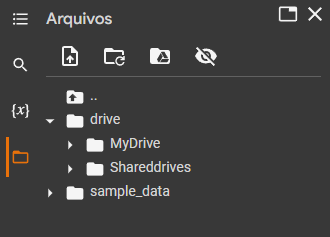
</br> 
Após isso, basta selecionar o local onde a planilha será salva, clicando com o botão direito sobre a pasta que será utilizada, seja ela de um drive compartilhado (Shareddrives) ou de um drive pessoal (MyDrive), como no exemplo a seguir.
</br> 
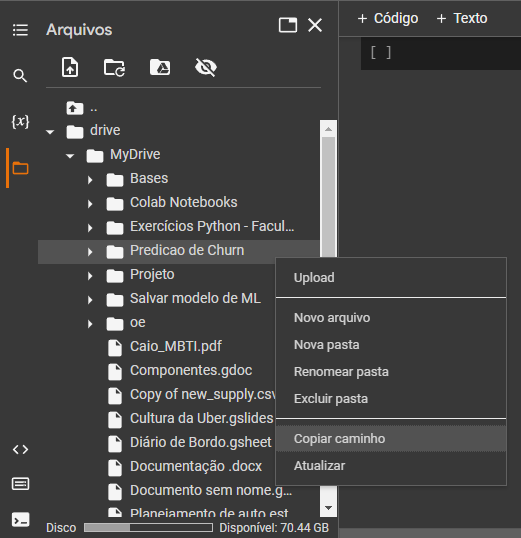

In [ ]:
#@markdown Nesta célula serão exportados o scaler e o modelo de aprendizado de
#@markdown máquina em si, para tal é necessário que os campos abaixos sejam
#@markdown preenchidos com o caminho ou path em que o arquivo será salvo.
#@title Vamos exportar o Modelo e o Scaler para utilizar em futuras predições
import joblib
from joblib import dump 

model_path = "" #@param {type:"string"}
scaler_path = "" #@param {type:"string"}

# Esta linha de código faz o download da planilha para o disco rígido da 
# máquina (computador) que executou as células 

dump(model, model_path + "/model_lgbm.model")

dump(scaler, scaler_path + "/scaler_model_lgbm.scaler")